# Bagging

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
#np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score, precision_score, accuracy_score,\
                            recall_score, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import BaggingClassifier

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado

In [2]:
# Tengo que recargar el archivo para que tome los cambios que se hicieron en el mismo
import importlib, sys

#importlib.reload(sys.modules['Preprocessing'])
from Preprocessing import *

In [3]:
df = preprod_tp1(df_data, df_decision)
df = replace_nulls_edad(df, 'media')
df.head()

,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,nombre_sede,cant_acompañantes,volveria
0,4d,117,hombre,73.5,0,0,1,fiumark_quilmes,0,0
1,4d,658,mujer,35.0,1,1,2,fiumark_quilmes,2,0
2,normal,794,hombre,32.7,0,0,3,fiumark_chacarita,0,0
3,4d,455,hombre,32.7,0,0,1,fiumark_palermo,0,0
4,4d,173,mujer,4.0,1,1,2,fiumark_palermo,2,1


In [4]:
df = encodear_atributos_categoricos(df)
df.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes,volveria
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2,0
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2,1


# Entrenamiento

In [5]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [6]:
X.head()

,tipo_de_sala_0,tipo_de_sala_1,tipo_de_sala_2,id_usuario,genero_0,genero_1,edad,amigos,parientes,precio_ticket,nombre_sede_0,nombre_sede_1,nombre_sede_2,cant_acompañantes
0,0,0,1,117,0,1,73.5,0,0,1,0,0,1,0
1,0,0,1,658,1,0,35.0,1,1,2,0,0,1,2
2,0,1,0,794,0,1,32.7,0,0,3,0,1,0,0
3,0,0,1,455,0,1,32.7,0,0,1,0,1,1,0
4,0,0,1,173,1,0,4.0,1,1,2,0,1,1,2


In [7]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

In [8]:
y.sum()

307

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)

In [10]:
y_train.value_counts()

0    367
1    233
Name: volveria, dtype: int64

In [11]:
y_test.value_counts()

0    127
1     74
Name: volveria, dtype: int64

### Random Search

In [12]:
params = {'max_samples': np.arange(1, 50), 
          'max_features': np.arange(1, 25),
          'n_estimators': np.arange(1, 50),
         }

model_bagging = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy")
)

rgscv = RandomizedSearchCV(
    model_bagging, params, n_iter=60, scoring='roc_auc', cv=5, return_train_score=True
).fit(X_train, y_train)

In [13]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.837208021766016
Best params {'n_estimators': 40, 'max_samples': 46, 'max_features': 9}


In [14]:
from sklearn.model_selection import KFold, StratifiedKFold

kf = StratifiedKFold(n_splits=5)

test_rocs = []
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    bagging = BaggingClassifier(
        base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10,random_state=117, criterion="entropy"),
        n_estimators = rgscv.best_params_['n_estimators'],
        max_samples = rgscv.best_params_['max_samples'],
        max_features = rgscv.best_params_['max_features']
    )
    bagging.fit(X.iloc[train_index], y.iloc[train_index])
    test_roc = roc_auc_score(y.iloc[test_index], bagging.predict(X.iloc[test_index]))
    print(f"fold {fold_idx}: auc roc score is {test_roc:.4f}")
    test_rocs.append(test_roc)
print(f"mean test auc roc is: {np.mean(test_rocs):.4f}")

fold 0: auc roc score is 0.7519
fold 1: auc roc score is 0.8076
fold 2: auc roc score is 0.8114
fold 3: auc roc score is 0.7370
fold 4: auc roc score is 0.7482
mean test auc roc is: 0.7712


## AUC ROC

In [22]:
roc_auc_score(y_test, bagging.predict_proba(X_test)[:,1])

0.8656629070014896

## Accuracy

In [23]:
accuracy_score(y_test, bagging.predict(X_test))

0.8159203980099502

## Precision

In [24]:
precision_score(y_test, bagging.predict(X_test))

0.7761194029850746

## Recall

In [25]:
recall_score(y_test, bagging.predict(X_test), pos_label=0)

0.8818897637795275

## F1-Score

In [26]:
f1_score(y_test, bagging.predict(X_test))

0.7375886524822697

## Matriz de Cofusion

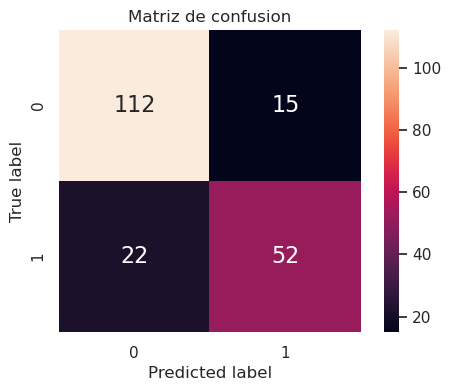

In [27]:
def plot_confusion_matrix(y_true, y_pred):
    names = sorted(set(y_true))
    cm = confusion_matrix(y_true, y_pred, names)
    df_cm = pd.DataFrame(cm, names, names)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


plot_confusion_matrix(y_test, bagging.predict(X_test))